In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

In [2]:
data = pd.read_csv("DataSet2.csv", sep=";")#, parse_dates=['Timestamp']) #, nrows=10)

In [84]:
columns = data.columns

In [3]:
data.head(5)

,Timestamp,ARO,SATUR_PRESSURE,BOIL_PERCENT,OCTANE_NUMBER,percent_01_LAB,percent_04_LAB,quality_01_LAB,pressure_01_LAB,consumption_09,...,temperature_08,temperature_14,temperature_01_LAB,temperature_21,temperature_22,temperature_23,temperature_24,consumption_01,pressure_11,temperature_20
0,01.01.2016 00:00:00,65.59,48.0,6.0,98.9,6.87640,64.05901,98.45841,56.06648,0.00292,...,134.7649,25.61035,90.86990,-3.72980,-7.13281,-1.0,11.86261,59.14596,70.77777,519.1353
1,01.01.2016 00:01:00,65.59,48.0,6.0,98.9,6.86923,64.01093,98.45134,56.04396,0.00292,...,134.8389,25.61035,90.90942,-3.72989,-7.13306,-1.0,11.86295,59.18106,70.93322,519.1353
2,01.01.2016 00:02:00,65.59,48.0,6.0,98.9,6.86095,63.99218,98.44153,56.01728,0.00292,...,134.6192,25.61055,90.88013,-3.73050,-7.13440,-1.0,11.86490,59.16980,70.03181,519.1346
3,01.01.2016 00:03:00,65.59,48.0,6.0,98.9,6.85725,63.98800,98.44115,56.01207,0.00292,...,134.6191,25.63477,90.87057,-3.73145,-7.13660,-1.0,11.86804,59.30387,70.46443,519.1337
4,01.01.2016 00:04:00,65.59,48.0,6.0,98.9,6.85561,63.98110,98.43896,56.00104,0.00292,...,134.6191,25.63477,90.90518,-3.73212,-7.13818,-1.0,11.87030,59.26101,69.81942,519.1330


In [84]:
def preprocess(df, K=5, dif=True):
    df = df.groupby(df.index // K).mean() #усреднение
    df_np = df.to_numpy()
    if dif:
        df_np = df_np[1:len(df_np), ...] - df_np[0:-1, ...] #дифференцирование
    df_np = (df_np - df_np.mean()) / df_np.std() #масштабирование
    df = pd.DataFrame(df_np, columns=df.columns)
    return df

In [8]:
#усреднение данных за 5 минут, дискретное дифференцирование, масштабирование
preprocess(data).to_csv("DataSet_preprocessed.csv")

NameError: name 'data' is not defined

In [6]:
preprocessed_data = pd.read_csv("DataSet_preprocessed.csv")

In [70]:
preprocessed_data.shape

(408095, 68)

In [9]:
def create_lag(data, size_of_lag=1):
    """
    data (N, Q)
    return lag (N, size_of_lag, Q)
    """
    data = data.to_numpy()
    print(data.shape)
    result = np.zeros((data.shape[0], size_of_lag, data.shape[1])) #(N, SL, Q)
    for i in range(size_of_lag): 
        result[:, i, :] = np.roll(data, -i, axis=0)
    return result[size_of_lag:data.shape[0] - size_of_lag, ...]

In [4]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

2022-11-01 16:08:08.120834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 16:08:08.120855: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:

def split_to_train_and_test(dataset, percent_of_test=20):
    K = 5
    values = create_lag(dataset, K)
    n_split = int((1 - percent_of_test/ 100) * dataset.shape[0])
    print(f"{n_split=}")
    train = values[:n_split, ...]
    test = values[n_split:, ...]
    train_X, train_y = train[:-K, ...], train[K:, 0, ...]
    test_X, test_y = test[:-K, ...], test[K:, 0, ...]
    train_X = np.transpose(train_X, axes=(0, 2, 1))
    test_X = np.transpose(test_X, axes=(0, 2, 1))
    print(f"{train_X.shape=}, {train_y.shape=}, {test_X.shape=}, {test_y.shape=}")
    return train_X, train_y, test_X, test_y

In [110]:
# from tensorflow.keras.utils import plot_model


In [6]:
def learn(train_X, train_y, test_X, test_y):
    model = Sequential()
    #batch_size, (time_steps, units)
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    # plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    model.summary()

    history = model.fit(train_X, train_y, epochs=10, batch_size=72, shuffle=False, validation_data=(test_X, test_y), verbose=2)
    return model, history

quality >= 90 :
L = 431204;  R = 2040480; len = 1609276

Частично данные из DataSet2

In [78]:
partial_data = preprocessed_data.iloc[431205 // 5:531205 // 5, 1:]
partial_data.shape

(20000, 67)

In [105]:
train_X, train_y, test_X, test_y = split_to_train_and_test(partial_data)

(20000, 67)
n_split=16000
train_X.shape=(15995, 67, 5), train_y.shape=(15995, 67), test_X.shape=(3985, 67, 5), test_y.shape=(3985, 67)


In [106]:
model, history = learn(train_X, train_y, test_X, test_y)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 67, 50)            11200     
                                                                 
 dense_8 (Dense)             (None, 67, 1)             51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
223/223 - 9s - loss: 0.1939 - val_loss: 0.1324 - 9s/epoch - 39ms/step
Epoch 2/10
223/223 - 7s - loss: 0.1920 - val_loss: 0.1326 - 7s/epoch - 30ms/step
Epoch 3/10
223/223 - 7s - loss: 0.1911 - val_loss: 0.1328 - 7s/epoch - 30ms/step
Epoch 4/10
223/223 - 7s - loss: 0.1904 - val_loss: 0.1327 - 7s/epoch - 29ms/step
Epoch 5/10
223/223 - 7s - loss: 0.1899 - val_loss: 0.1325 - 7s/epoch - 30ms/step
Epoch 6/10
223/223 - 7s - loss: 0.1892 -

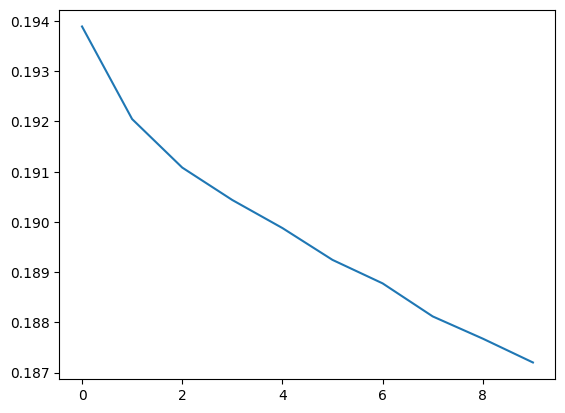

In [107]:
plt.plot(history.history['loss'], label='train')


In [108]:
predicted = model.predict(test_X)
print(predicted.shape)

125/125 [==============================] - 1s 9ms/step
(3985, 67, 1)


In [109]:
predicted_values = predicted[:100, ...]
print(f"{predicted_values.shape=}")

for i in range(predicted_values.shape[1]):
    plt.plot(predicted_values[:, i, 0], color="red", label="prediction")
    plt.plot(test_y[:100, i], color="green", label="origin")
    plt.xlabel("Time")
    plt.ylabel(str(columns[i + 1]))
    plt.legend()
    plt.savefig("plots/partionDataSet2/" + str(i) + " " + str(columns[i + 1]) + '.png')
    # plt.show()
    plt.clf()

predicted_values.shape=(100, 67, 1)


<Figure size 640x480 with 0 Axes>

Данные https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


In [111]:
dataset = pd.read_csv('../../materials/pollution.csv')
# dataset.drop(columns=["date"], inplace=True)
print(dataset.head(5))
dataset.to_csv('../../materials/pollution.csv', index=False)

   pollution  dew  temp   press  wnd_spd  snow  rain
0      129.0  -16  -4.0  1020.0     1.79     0     0
1      148.0  -15  -4.0  1020.0     2.68     0     0
2      159.0  -11  -5.0  1021.0     3.57     0     0
3      181.0   -7  -5.0  1022.0     5.36     1     0
4      138.0   -7  -5.0  1022.0     6.25     2     0


In [109]:
dataset = pd.read_csv('../../materials/pollution.csv')


In [110]:
dataset = preprocess(dataset)

In [111]:
dataset.info

<bound method DataFrame.info of       pollution       dew      temp     press   wnd_spd      snow      rain
0     -1.520064  0.184166 -0.046135  0.119682  0.312674  0.036773 -0.000075
1      1.584399 -0.036923  0.027561  0.092046  0.621923 -0.055347 -0.000075
2      0.313135 -0.018499 -0.000075  0.045985  0.720400 -0.009287 -0.000075
3     -0.976553  0.045985 -0.027711  0.036773  0.572639  0.092046 -0.000075
4     -3.307203 -0.036923 -0.064559 -0.110620  0.778160  0.230227 -0.000075
...         ...       ...       ...       ...       ...       ...       ...
8754  -0.939705 -0.258012 -0.211952  0.248651  2.107736 -0.000075 -0.000075
8755  -0.230376 -0.129044 -0.138256  0.202590  2.977169 -0.000075 -0.000075
8756   0.128894 -0.073771  0.110470  0.064410  2.075033 -0.000075 -0.000075
8757  -0.073771 -0.046135  0.055197 -0.046135  1.930864 -0.000075 -0.000075
8758   0.009137  0.092046 -0.129044  0.073622  1.346451 -0.000075 -0.000075

[8759 rows x 7 columns]>

In [112]:
dataset.head()

,pollution,dew,temp,press,wnd_spd,snow,rain
0,-1.520064,0.184166,-0.046135,0.119682,0.312674,0.036773,-0.000075
1,1.584399,-0.036923,0.027561,0.092046,0.621923,-0.055347,-0.000075
2,0.313135,-0.018499,-0.000075,0.045985,0.720400,-0.009287,-0.000075
3,-0.976553,0.045985,-0.027711,0.036773,0.572639,0.092046,-0.000075
4,-3.307203,-0.036923,-0.064559,-0.110620,0.778160,0.230227,-0.000075


In [113]:
from tslearn.clustering import TimeSeriesKMeans


In [114]:
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=50)
# model.fit_predict(dataset)

In [115]:
from sklearn.cluster import KMeans


In [116]:
W = 5
dataset = dataset.to_numpy()

In [118]:
windows = np.array([dataset[i:i+W].flatten() for i in range(dataset.shape[0] - W)])
windows.shape


(8754, 35)

In [124]:
N_clusters = 5
model1 = KMeans(n_clusters=N_clusters, max_iter=100)
res = model1.fit_predict(windows)

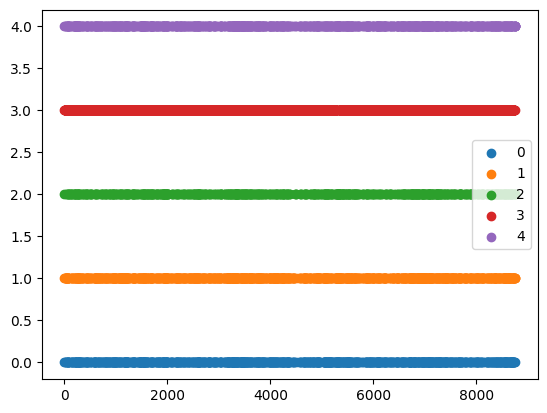

In [127]:

for i in range(N_clusters):
    plt.hist()
plt.legend()

In [140]:
def calc_RLE(lst):
	cnt = dict()
	i = 0
	while i < len(lst):
		tmp = 
		for j in range(i, len(lst)):
			if lst[j] != lst[i]:
				break
			tmp += 1
	encoded_message = ""
	i = 0

	while (i <= len(message)-1):
		count = 1
		ch = message[i]
		j = i
		while (j < len(message)-1):
			if (message[j] == message[j+1]):
				count = count+1
				j = j+1
			else:
				break
		encoded_message=encoded_message+str(count)+ch
		i = j+1
	return encoded_message

#Provide different values for message and test your program
encoded_message=encode("ABBBBCCCCCCCCAB")
print(encoded_message)


IndentationError: expected an indented block after 'while' statement on line 4 (3224479076.py, line 5)

In [30]:
columns = dataset.columns

In [113]:
train_X, train_y, test_X, test_y = split_to_train_and_test(dataset)


(43800, 7)
n_split=35040
train_X.shape=(35035, 7, 5), train_y.shape=(35035, 7), test_X.shape=(8745, 7, 5), test_y.shape=(8745, 7)


In [114]:
model, history = learn(train_X, train_y, test_X, test_y)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 7, 50)             11200     
                                                                 
 dense_9 (Dense)             (None, 7, 1)              51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
487/487 - 5s - loss: 161.0285 - val_loss: 156.8850 - 5s/epoch - 9ms/step
Epoch 2/10
487/487 - 3s - loss: 154.3784 - val_loss: 151.9624 - 3s/epoch - 5ms/step
Epoch 3/10
487/487 - 3s - loss: 150.1037 - val_loss: 148.0692 - 3s/epoch - 5ms/step
Epoch 4/10
487/487 - 3s - loss: 146.3915 - val_loss: 144.5203 - 3s/epoch - 5ms/step
Epoch 5/10
487/487 - 3s - loss: 142.8954 - val_loss: 141.1337 - 3s/epoch - 5ms/step
Epoch 6/10
487/487 - 2s -

In [118]:
predicted = model.predict(test_X)
print(predicted.shape)

274/274 [==============================] - 1s 2ms/step
(8745, 7, 1)


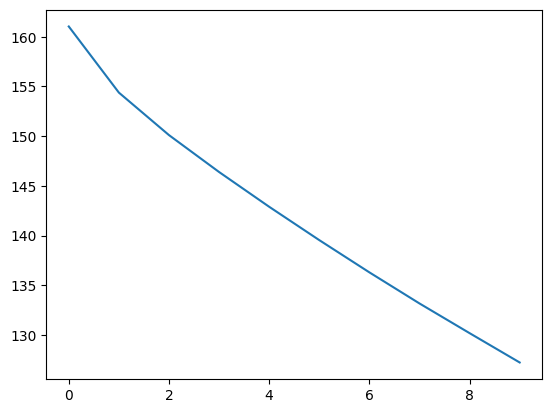

In [119]:
plt.plot(history.history['loss'], label='train')


In [127]:

predicted_values = predicted[100:200, ...]
print(f"{predicted_values.shape=}")

for i in range(predicted_values.shape[1]):
    plt.plot(predicted_values[:, i, 0], color="red", label="prediction")
    plt.plot(test_y[100:200, i], color="green", label="origin")
    plt.xlabel("Time")
    plt.ylabel(str(columns[i]))
    plt.legend()
    plt.savefig("plots/smallDataSet/" + str(i) + " " + str(columns[i]) + '.png')
    # plt.show()
    plt.clf()

predicted_values.shape=(100, 7, 1)


<Figure size 640x480 with 0 Axes>

In [16]:
data1 = pd.read_csv("MiningProcess_Flotation_Plant_Database.csv")

In [17]:
data1.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235",...,"250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
1,2017-03-10 01:00:00,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532",...,"248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2,2017-03-10 01:00:00,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874",...,"248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
3,2017-03-10 01:00:00,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487",...,"251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"
4,2017-03-10 01:00:00,"55,2","16,98","3033,69","558,167","400,254","10,0697","1,74","250,203","252,136",...,"248,928","452,441","452,9","450,523","453,67","462,598","443,682","425,679","66,91","1,31"


In [18]:
data2 = preprocess(data1)

/tmp/ipykernel_426808/3816599972.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  df = df.groupby(df.index //5).mean() #усреднение
/home/anna/.local/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/anna/.local/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/anna/.local/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
data2.head()

""
0
1
2
3
4


In [45]:
309600 64
241200 64
216001 84
226801 84
93601 88
201600 88
126000 88
237600 88
259200

SyntaxError: invalid syntax (3787536431.py, line 1)